In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

In [2]:
# Define the path to your CSV file
# You may have to make this path more specific to the location of your file.
csv_path = "BTC_USD_2025.csv"

# Read the CSV, parse 'Date' column as datetime, and set it as the index
data = pd.read_csv(
    csv_path,
    parse_dates=["Date"],
    dayfirst=False,
    index_col="Date"
)

# Sort the DataFrame by the Date index in ascending order
data.sort_index(inplace=True)

### Data preprocessing

In [3]:
# Clean the "Close" column
data["Close"] = data["Close"].replace(',', '', regex=True)
data["Close"] = pd.to_numeric(data["Close"], errors='coerce')
data["Close"].replace([np.inf, -np.inf], np.nan, inplace=True)
data.dropna(subset=["Close"], inplace=True)

C:\Users\hp\AppData\Local\Temp\ipykernel_21352\3431076274.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data["Close"].replace([np.inf, -np.inf], np.nan, inplace=True)


### Handle missing values

### Create a time plot

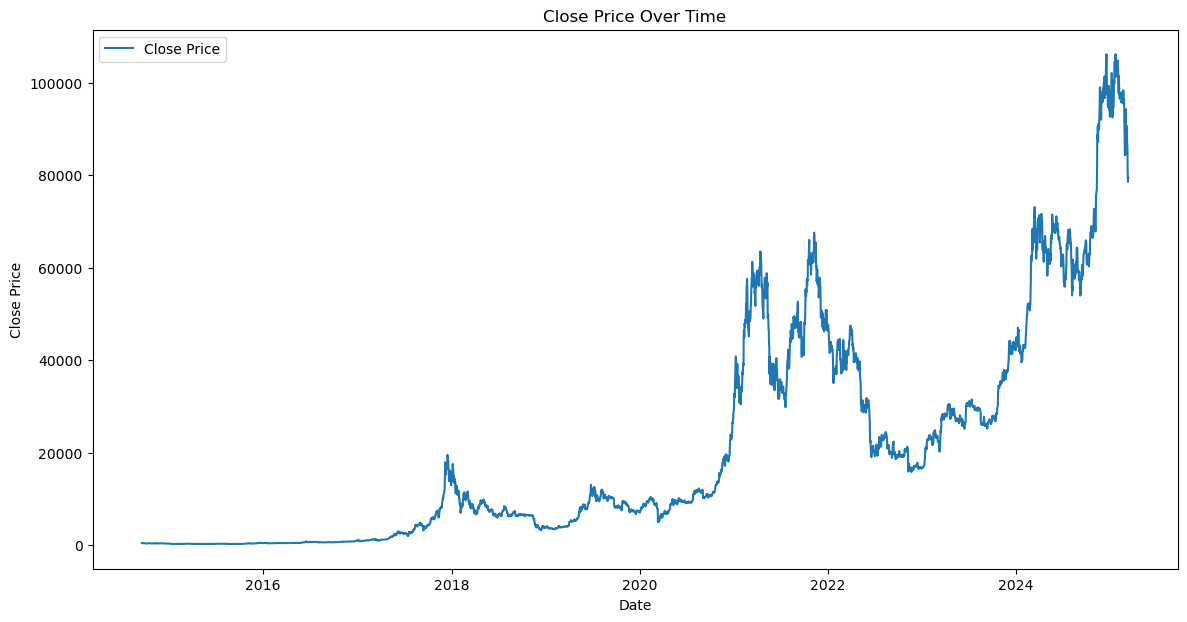

In [4]:
# Plotting the original Close price
plt.figure(figsize=(14, 7))
plt.plot(data.index, data["Close"], label='Close Price')
plt.title('Close Price Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()


<Axes: xlabel='Date', ylabel='Close'>

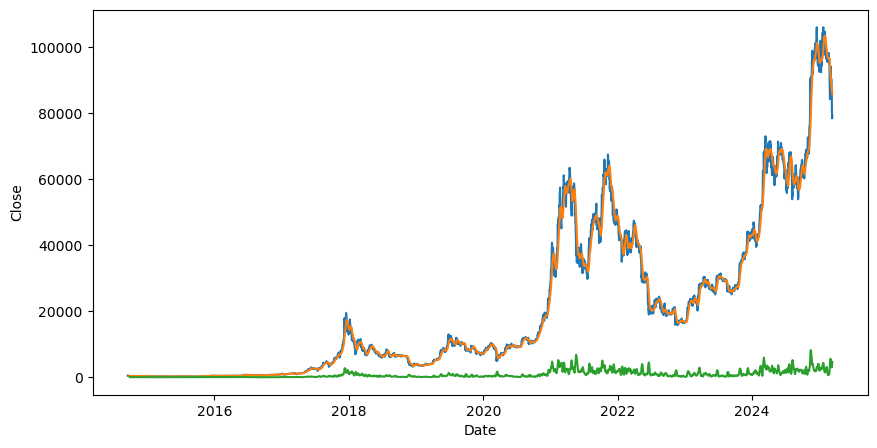

In [5]:


# Test 1 'Rolling Window'
# To check wheather the mean and vaiance are stationary or not with respect to time
# use Rolling window method
data['roll_mean'] = data.Close.rolling(window=12).mean()
data['roll_std'] = data.Close.rolling(window=12).std()

plt.figure(figsize =(10,5))
sns.lineplot(data = data, x = data.index, y = data.Close)
sns.lineplot(data = data, x = data.index, y = data.roll_mean)
sns.lineplot(data = data, x = data.index, y = data.roll_std)

#### Check for stationarity and perform differencing if necessary

In [6]:
# Perform the Augmented Dickey-Fuller test on the original series
result_original = adfuller(data["Close"], autolag ='AIC')
stats =pd.Series(result_original[0:4], index = ['Test Statistic','P-value','Lags used', 'No of observations used'])
stats


Test Statistic               -0.762938
P-value                       0.829767
Lags used                    29.000000
No of observations used    3799.000000
dtype: float64

In [7]:
for key,values in result_original[4].items():
    print("criticality",key,":",values)

criticality 1% : -3.4320724859265566
criticality 5% : -2.86230109957308
criticality 10% : -2.567175143302213


In [8]:
print(f"ADF Statistic (Original): {result_original[0]:.4f}")
print(f"p-value (Original): {result_original[1]:.4f}")

if result_original[1] < 0.05:
    print("Interpretation: The original series is Stationary.\n")
else:
    print("Interpretation: The original series is Non-Stationary.\n")

# Apply first-order differencing
data['Close_Diff'] = data['Close'].diff()

# Perform the Augmented Dickey-Fuller test on the differenced series
result_diff = adfuller(data["Close_Diff"].dropna())
print(f"ADF Statistic (Differenced): {result_diff[0]:.4f}")
print(f"p-value (Differenced): {result_diff[1]:.4f}")
if result_diff[1] < 0.05:
    print("Interpretation: The differenced series is Stationary and p-value < 0.05.")
else:
    print("Interpretation: The differenced series is Non-Stationary and p-value > 0.05.")


ADF Statistic (Original): -0.7629
p-value (Original): 0.8298
Interpretation: The original series is Non-Stationary.

ADF Statistic (Differenced): -8.7794
p-value (Differenced): 0.0000
Interpretation: The differenced series is Stationary and p-value < 0.05.


The results of our Augmented Dickey-Fuller test indicate that our original series is, in fact, non-stationary, so using an ARIMA out-of-the-box on the original data would be a mistake.

The ADF test on a differenced version of the data indicates that the differenced version is stationary.
To perform differencing, we subtract each observation from the previous one to give us a new time series of first differences. (The new time series is now one element shorter than the original.) If the differenced series is still not stationary, we can take a second difference by differencing the original series again, and we can continue differencing the series until it finally becomes stationary. The order of differencing required is the minimum number of differences needed to get a series with no autocorrelation.

In [9]:
# input arguments to the function test_stationary are df and the column'Close'
# here the stationarity has to be checked again and again.So a function file is created
# Custom function to apply differencing and check stationarity
def test_stationary(dataFrame, var, diff_order, window=12):
    # Apply differencing dynamically
    dataFrame[f'{var}_Diff'] = dataFrame[var].diff(periods=diff_order)

    # Calculate rolling statistics
    dataFrame['roll_mean'] = dataFrame[f'{var}_Diff'].rolling(window=window).mean()
    dataFrame['roll_std'] = dataFrame[f'{var}_Diff'].rolling(window=window).std()

    # Perform ADF test
    adf_Test = adfuller(dataFrame[f'{var}_Diff'].dropna(), autolag='AIC')
    
    print(f"ADF Statistic (Differenced): {adf_Test[0]:.4f}")
    print(f"p-value (Differenced): {adf_Test[1]:.4f}")
    if result_diff[1] < 0.05:
        print("Interpretation: The differenced series is Stationary and p-value < 0.05.")
    else:
        print("Interpretation: The differenced series is Non-Stationary and p-value > 0.05.")
    
    stats = pd.Series(adf_Test[0:4], index=['Test Statistic', 'P-value', 'Lags used', 'No of observations used'])
    print(stats)

    # Display critical values
    for key, values in adf_Test[4].items():
        print("Critical value ({}): {:.4f}".format(key, values))

    # Plotting
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=dataFrame, x=dataFrame.index, y=f'{var}_Diff', label=f'Differenced {var} (d={diff_order})')
    sns.lineplot(data=dataFrame, x=dataFrame.index, y='roll_mean', label=f'Rolling Mean (window={window})', linestyle='--')
    sns.lineplot(data=dataFrame, x=dataFrame.index, y='roll_std', label=f'Rolling Std Dev (window={window})', linestyle='--')
    plt.title(f'Stationarity Test for {var} with d={diff_order} and window={window}')
    plt.show()


ADF Statistic (Differenced): -8.7794
p-value (Differenced): 0.0000
Interpretation: The differenced series is Stationary and p-value < 0.05.
Test Statistic            -8.779437e+00
P-value                    2.398880e-14
Lags used                  3.000000e+01
No of observations used    3.797000e+03
dtype: float64
Critical value (1%): -3.4321
Critical value (5%): -2.8623
Critical value (10%): -2.5672


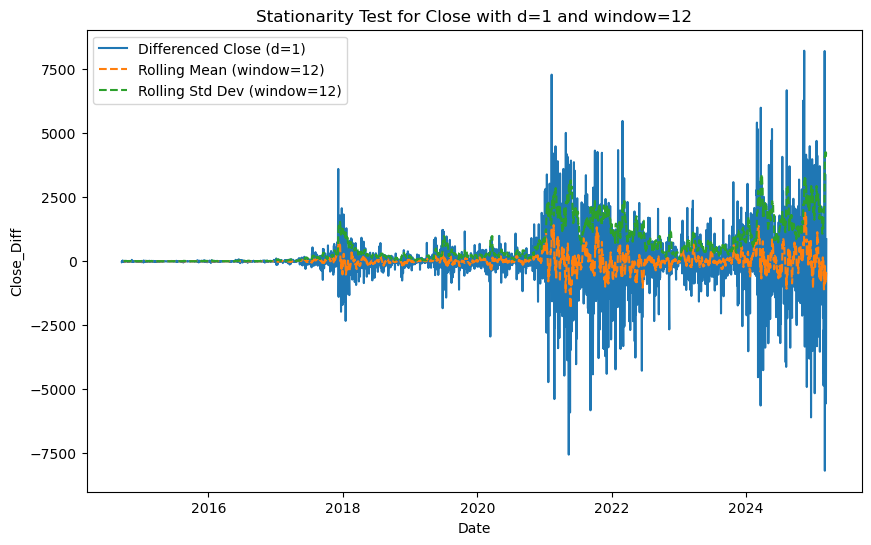

In [10]:
test_stationary(data, 'Close',1, window=12)

#### Model identification, finding the ARIMA terms

Consider the p, d, and q terms that go into our ARIMA model. 


### ARIMA Model (p,d,q)
- AR -Auto Regressive  (p)
- I - Integrated   (d)
- MA - Moving Average (q)

order = [p,d,q]

- 1.  d  denotes  (I) Integration
    - d, refers to the order of differencing,to make our data stationary
    - d =1 , when we shift the data by 1 time step, then we find the difference
    - d = 12, when we shift the data by 12 time steps, then we find the difference

- 2. p denotes Partial Auto Correlation Function (PACF)
    - The parameter p, is the number of lagged observations. By considering p, we effectively determine how far back in time we go when trying to predict the current observation.
    - The number of lags where PACF cuts off is p.

- 3. q denotes Moving average  | Auto Correlation (use ACF)
    - parameter q refers to the order of the moving average (MA) part of the model. It represents the number of lagged forecast errors included in the model.moving average in ARIMA captures the relationship between an observation and the residual errors from a moving average model applied to lagged observations.
    - The number of lags where ACF cuts off is q

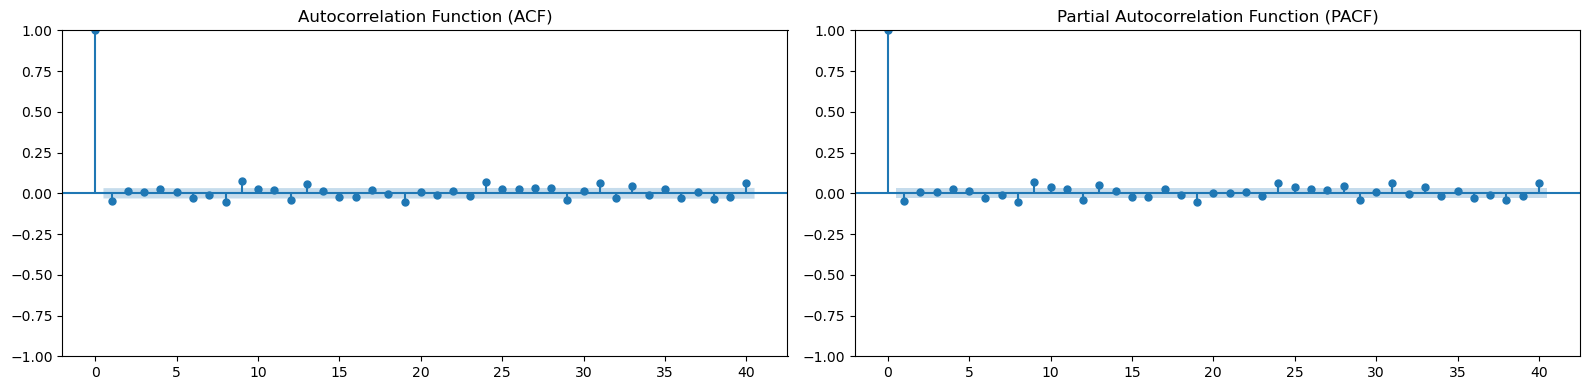

In [11]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# Plot ACF and PACF for the differenced series
fig, axes = plt.subplots(1, 2, figsize=(16, 4))

# ACF plot
plot_acf(data['Close_Diff'].dropna(), lags=40, ax=axes[0])
axes[0].set_title('Autocorrelation Function (ACF)')

# PACF plot
plot_pacf(data['Close_Diff'].dropna(), lags=40, ax=axes[1])
axes[1].set_title('Partial Autocorrelation Function (PACF)')

plt.tight_layout()
plt.show()

To determine the values of $p$, $d$, and $q$ from the attached ACF and PACF plots:

### Step 1: Determine $d$ (Differencing Order)

* Check for stationarity in the original time series. If the series is non-stationary (trending or seasonally varying), apply differencing.
* If the ACF shows a slow decay and the PACF shows a significant spike at lag 1, it indicates the data may need differencing. Typically, $d = 1$ is common for making data stationary.over-differenced data, which causes loss of valuable information and results in a flat forecast.

### Step 2: Determine $q$ (Moving Average Order) from ACF

* The value of $q$ corresponds to the lag at which the ACF plot cuts off (becomes insignificant).
* From the ACF plot in the image:

  * There is a significant spike at lag 1, and then the values drop sharply and remain around zero.
  * This suggests that $q = 1$.

### Step 3: Determine $p$ (Autoregressive Order) from PACF

* The value of $p$ corresponds to the lag at which the PACF plot cuts off (becomes insignificant).
* From the PACF plot in the image:

  * There is a significant spike at lag 1, and the remaining values are close to zero.
  * This suggests that $p = 1$.

### Conclusion:

* The ARIMA model order can be expressed as:

  $$
  \text{order} = (p, d, q) = (1, 1, 1)
  $$

This indicates that the AR part takes into account 1 lag, the I part involves first-order differencing, and the MA part accounts for 1 lag as well. Let me know if you need help with model implementation.


#### Parameter estimation 

- To be clear, the p, d, and q values in ARIMA represent the model's order (lags for autoregression, differencing, and moving average terms), but they are not the actual parameters being estimated. Once the p, d, and q values are chosen, the model estimates additional parameters, such as coefficients for the autoregressive and moving average terms, through maximum likelihood estimation (MLE).

#### Forecasting

- To forecast using an ARIMA model, start by using the fitted model to predict future values based on the data. Once predictions are made, it's helpful to visualize them by plotting the predicted values alongside the actual values. This is accomplished because we use a train/test workflow, where the data is split into training and testing sets. Doing this lets us see how well the model performs on unseen data.

##### 1. Use a train/test workflow

In [12]:
# Split data into train and test
train_size = int(len(data) * 0.7)
train, test = data.iloc[:train_size], data.iloc[train_size:]


In [13]:

# ARIMA model
arima_model = ARIMA(train["Close"], order=(1,1,1))  
arima_fit = arima_model.fit()
arima_forecast = arima_fit.forecast(steps=len(test))

# ARIMAX model (adding exogenous variable if available, e.g., 'Volume')
if 'Volume' in data.columns:
    arimax_model = SARIMAX(train["Close"], exog=train["Volume"], order=(1,1,1))
    arimax_fit = arimax_model.fit()
    arimax_forecast = arimax_fit.forecast(steps=len(test), exog=test["Volume"])
else:
    print("No exogenous variable available for ARIMAX; using ARIMA instead.")
    arimax_forecast = arima_forecast

# SARIMA model
sarima_model = SARIMAX(train["Close"], order=(1,1,1), seasonal_order=(1,1,1,12))
sarima_fit = sarima_model.fit()
sarima_forecast = sarima_fit.forecast(steps=len(test))



c:\Users\hp\anaconda3\envs\tf_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\hp\anaconda3\envs\tf_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\hp\anaconda3\envs\tf_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\hp\anaconda3\envs\tf_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\hp\anaconda3\envs\tf_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, 

##### 2. Visualize our time series

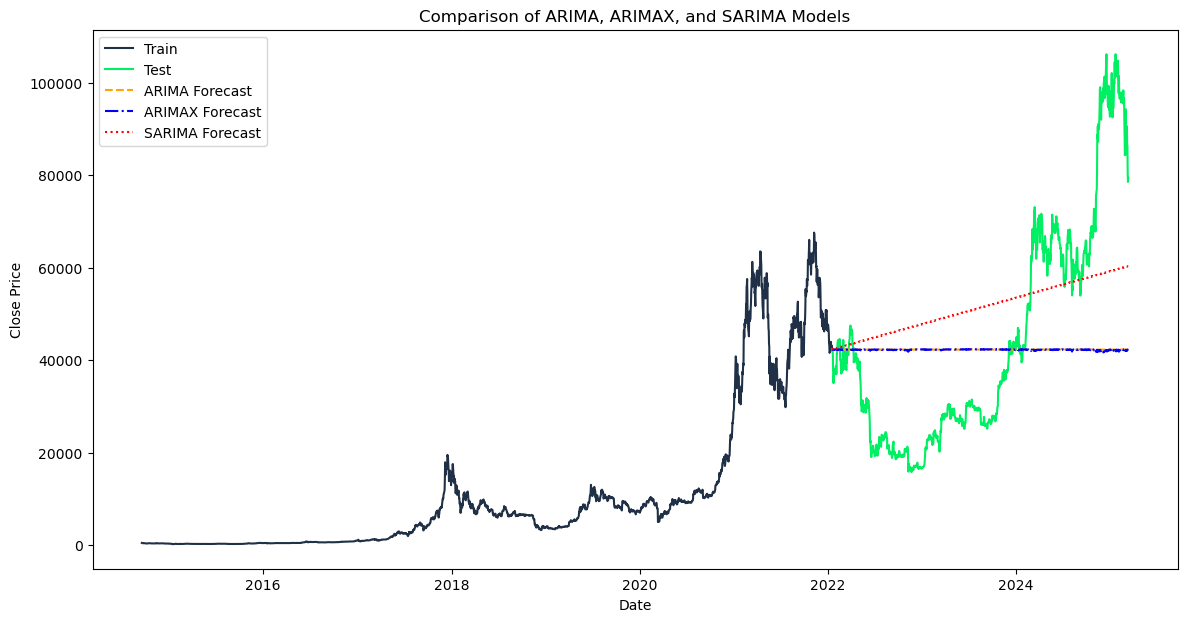

In [14]:
# Forecast
# Plot the results
plt.figure(figsize=(14,7))

# Actual data
plt.plot(train.index, train["Close"], label='Train', color='#203147')
plt.plot(test.index, test["Close"], label='Test', color='#01ef63')

# Forecasts
plt.plot(test.index, arima_forecast, label='ARIMA Forecast', color='orange', linestyle='--')
plt.plot(test.index, arimax_forecast, label='ARIMAX Forecast', color='blue', linestyle='-.')
plt.plot(test.index, sarima_forecast, label='SARIMA Forecast', color='red', linestyle=':')

# Title and labels
plt.title('Comparison of ARIMA, ARIMAX, and SARIMA Models')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()



##### 3. Evaluate model statistics
We check out the AIC and BIC model statistics. Lower values mean the model fits better, but we might also compare the results with those from simpler models to avoid overfitting. I'm printing the numbers here but they make the most sense in the context of comparing to other ARIMA models on the same data, in order to find the ARIMA model that works best.

In [15]:
# Error comparison
arima_rmse = np.sqrt(mean_squared_error(test["Close"], arima_forecast))
arimax_rmse = np.sqrt(mean_squared_error(test["Close"], arimax_forecast))
sarima_rmse = np.sqrt(mean_squared_error(test["Close"], sarima_forecast))

print(f"ARIMA RMSE: {arima_rmse:.4f}")
print(f"ARIMAX RMSE: {arimax_rmse:.4f}")
print(f"SARIMA RMSE: {sarima_rmse:.4f}")


print(f"AIC ARIMA: {arima_fit.aic}")
print(f"BIC ARIMA: {arima_fit.bic}")
print(f"AIC ARIMAX: {arimax_fit.aic}")
print(f"BIC ARIMAX: {arimax_fit.bic}")
print(f"AIC SARIMA: {sarima_fit.aic}")
print(f"BIC SARIMA: {sarima_fit.bic}")

ARIMA RMSE: 24269.2071
ARIMAX RMSE: 24318.8487
SARIMA RMSE: 21436.9202
AIC ARIMA: 43159.15002451549
BIC ARIMA: 43176.829621124125
AIC ARIMAX: 43150.13379543043
BIC ARIMAX: 43173.70659090861
AIC SARIMA: 43020.81667939229
BIC SARIMA: 43050.2602270132


In [16]:
# Model evaluation metrics
comparison_data = {
    "Model": ["ARIMA", "ARIMAX", "SARIMA"],
    "RMSE": [arima_rmse, arimax_rmse, sarima_rmse],
    "AIC": [arima_fit.aic, arimax_fit.aic, sarima_fit.aic],
    "BIC": [arima_fit.bic, arimax_fit.bic, sarima_fit.bic]
}

# Creating the DataFrame
comparison_df = pd.DataFrame(comparison_data)

# Display the comparison table
print(comparison_df)

# Pretty display with rounded values
comparison_df = comparison_df.round(4)
print("\nComparison Table:")
print(comparison_df.to_string(index=False))

    Model          RMSE           AIC           BIC
0   ARIMA  24269.207130  43159.150025  43176.829621
1  ARIMAX  24318.848718  43150.133795  43173.706591
2  SARIMA  21436.920163  43020.816679  43050.260227

Comparison Table:
 Model       RMSE        AIC        BIC
 ARIMA 24269.2071 43159.1500 43176.8296
ARIMAX 24318.8487 43150.1338 43173.7066
SARIMA 21436.9202 43020.8167 43050.2602


#### Things to Consider for Better ARIMA Forecasting
- Overfitting and underfitting
    If we choose incorrect p, d, and q values, it can lead to overfitting or underfitting. 

- Stationarity
    Differencing or transformations such as log transformations or seasonal adjustments can be used to make non-stationary data stationary.

- Seasonality
    Daily, weekly, and yearly are some of the fixed intervals over which many real-world datasets exhibit repeated patterns. Disregarding these seasonal patterns can result in improper forecasting. In the context of seasonality, we need seasonal differences and seasonal AR and MA terms in addition to p and q values. Keep in mind that a series can have more than one kind of seasonality.

- Residual analysis
    One of the most important steps in ARIMA modeling is to check if the residual series that is generated is stationary. Residuals are the difference between observed values and those produced by a model. By looking at the residuals, we can check if our model is able to find and work with the dynamics in the data. The residuals should show a random scatter without indicating any trends or correlations.

    When the residuals show patterns or correlations, it means that there is information somewhere that the model has not completely captured. Statistical tests and visual diagnostics, including the Ljung-Box test, as well as histograms and other diagnostic plots can be used to verify that the model is adequate.


### LSTM predictions

Epoch 1/50
82/82 [==============================] - 7s 48ms/step - loss: 0.0023 - val_loss: 4.9230e-04
Epoch 2/50
82/82 [==============================] - 3s 35ms/step - loss: 1.7193e-04 - val_loss: 4.7045e-04
Epoch 3/50
82/82 [==============================] - 3s 37ms/step - loss: 1.5469e-04 - val_loss: 4.5959e-04
Epoch 4/50
82/82 [==============================] - 3s 37ms/step - loss: 1.4637e-04 - val_loss: 5.6766e-04
Epoch 5/50
82/82 [==============================] - 3s 36ms/step - loss: 1.3515e-04 - val_loss: 5.4271e-04
Epoch 6/50
82/82 [==============================] - 3s 34ms/step - loss: 1.2923e-04 - val_loss: 5.7593e-04
Epoch 7/50
82/82 [==============================] - 3s 38ms/step - loss: 1.2259e-04 - val_loss: 4.0690e-04
Epoch 8/50
82/82 [==============================] - 3s 35ms/step - loss: 1.4005e-04 - val_loss: 3.8212e-04
Epoch 9/50
82/82 [==============================] - 3s 36ms/step - loss: 1.2118e-04 - val_loss: 4.4422e-04
Epoch 10/50
82/82 [======================

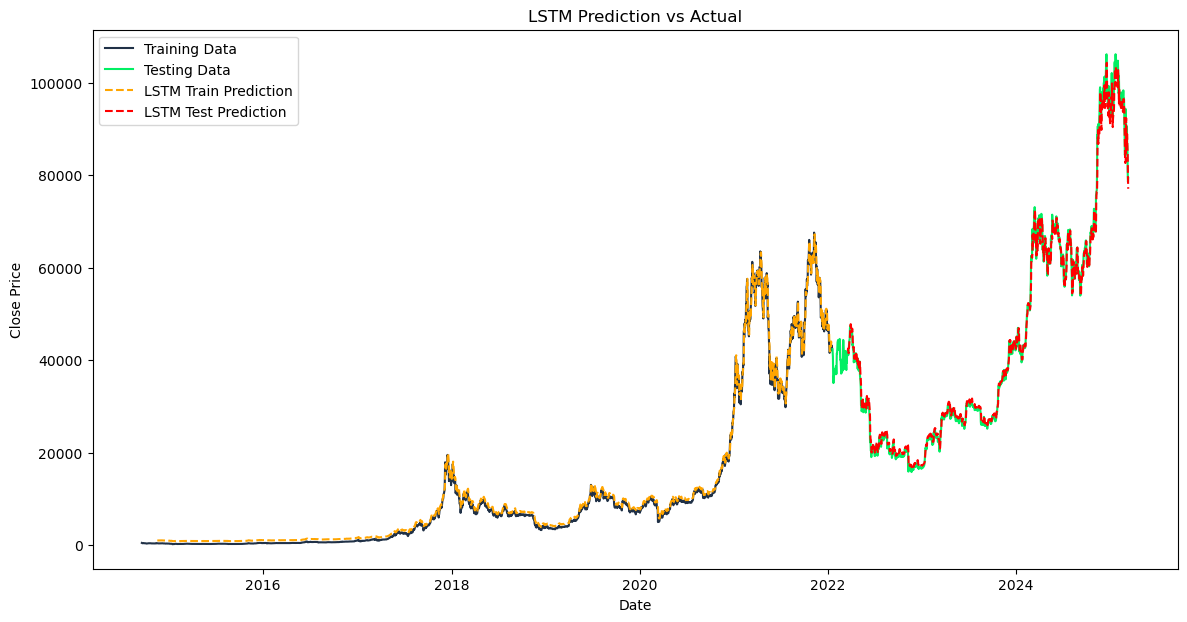

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Step 1: Data Preprocessing
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1, 1))

# Prepare training and testing data
train_size = int(len(scaled_data) * 0.7)
train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]

# Function to create sequences for LSTM
def create_sequences(data, seq_length):
    x, y = [], []
    for i in range(len(data) - seq_length):
        x.append(data[i:(i + seq_length)])
        y.append(data[i + seq_length])
    return np.array(x), np.array(y)

seq_length = 60  # Sequence length (can be adjusted)

# Create sequences
x_train, y_train = create_sequences(train_data, seq_length)
x_test, y_test = create_sequences(test_data, seq_length)

# Reshape to fit LSTM input [samples, time steps, features]
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

# Step 2: Model Building
model = Sequential([
    LSTM(50, return_sequences=False, input_shape=(seq_length, 1)),
    Dense(25),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

# Step 3: Training the Model
model.fit(x_train, y_train, epochs=50, batch_size=32, validation_data=(x_test, y_test), verbose=1)

# Step 4: Prediction
train_predict = model.predict(x_train)
test_predict = model.predict(x_test)

# Inverse transformation to original scale
train_predict = scaler.inverse_transform(train_predict)
y_train = scaler.inverse_transform(y_train.reshape(-1, 1))
test_predict = scaler.inverse_transform(test_predict)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate MSE
train_mse = mean_squared_error(y_train, train_predict)
test_mse = mean_squared_error(y_test, test_predict)

print(f"Training MSE: {train_mse:.4f}")
print(f"Testing MSE: {test_mse:.4f}")

# Step 5: Plot the results
plt.figure(figsize=(14,7))

# Plot training data
plt.plot(data.index[:train_size], scaler.inverse_transform(train_data), label='Training Data', color='#203147')

# Plot testing data
plt.plot(data.index[train_size:], scaler.inverse_transform(test_data), label='Testing Data', color='#01ef63')

# Plot LSTM predictions
plt.plot(data.index[seq_length:train_size], train_predict, label='LSTM Train Prediction', color='orange', linestyle='--')
plt.plot(data.index[train_size + seq_length:], test_predict, label='LSTM Test Prediction', color='red', linestyle='--')

plt.title('LSTM Prediction vs Actual')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()
